<div style="background-color:#BFBEBE; text-align: center;">
<img src="imgs/icon.png" style="width:600px">
</div>

# Analyzing and Hashing Audio Fingerprints

Princípios: 
* [Shazam](https://www.shazam.com/)
* [An Industrial-Strength Audio Search Algorithm](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)
* [A Fingerprint for Audio](https://medium.com/intrasonics/a-fingerprint-for-audio-3b337551a671)

`pip install youtube-downloader`

In [1]:
import os
import youtube_dl
import subprocess
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram
from IPython.display import Audio, display
from skimage.feature import peak_local_max

plt.rcParams.update({'font.size': 18})

In [2]:
def option_youtube(song, link):
    options = {
        'format': 'bestaudio/best',
        'extractaudio': True,
        'audioformat': 'wav',
        'outtmpl': 'audios/youtube/' + song + '.%(ext)s'}
    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([link])

In [ ]:
!mkdir audios/youtube

### Artist: Daft Punk
* Featured artists: Pharrell Williams, Nile Rodgers
* Album: Random Access Memories - Released: 2013
* Genre: Dance/Electronic

### Artist: Katy Perry
* Album: Gzone Rainbow Anthems - Released: 2016
* Nominations: Grammy Award for Record of the Year, MORE
* Genres: Dance/Electronic, Teen Pop, Rock, Pop

In [3]:
option_youtube('Daft_Punk', 'https://www.youtube.com/watch?v=5NV6Rdv1a3I')
option_youtube('Katy_Perry', 'https://www.youtube.com/watch?v=QGJuMBdaqIw')

[youtube] 5NV6Rdv1a3I: Downloading webpage
[youtube] 5NV6Rdv1a3I: Downloading player 5f8f5b0f


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


DownloadError: ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.

In [4]:
for i in os.listdir("audios/youtube"):
    command = f'ffmpeg -i "audios/youtube/{i}" -vn -ac 1 -ar 44100 -f wav "audios/youtube/{i.split(".")[0]}.wav"'
    subprocess.run(command, shell=True)
    print(command)

In [ ]:
!rm audios/youtube/*.webm
!curl https://meriatdatasets.blob.core.windows.net/public/digital-audio-processing/sax_riff_mono.wav -o audios/sax_riff_mono.wav
!ls audios/youtube

## Frequency Uncertainty

In [5]:
def beat_freq(f, max_time, rate):
    t = np.linspace(0, max_time, rate*max_time)
    signal = np.sin(2*np.pi*f*t)
    display(Audio(data=signal, rate=rate))
    return signal

In [6]:
signal_250 = beat_freq(250.0, 1, 11025)
signal_275 = beat_freq(275.0, 1, 11025)
signal_300 = beat_freq(300.0, 1, 11025)

In [7]:
signals = np.hstack((signal_275+signal_300, signal_275+signal_250))

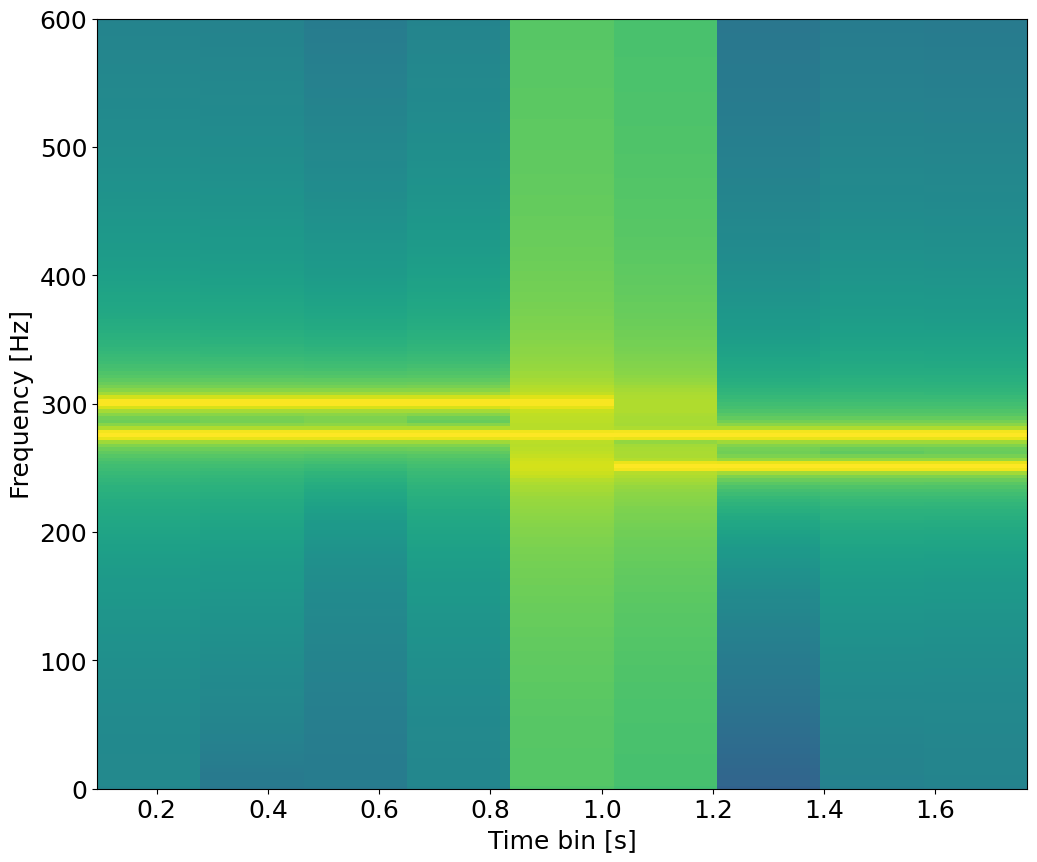

In [8]:
fig1 = plt.figure(figsize=(12, 10), facecolor='white')
plt.specgram(signals, NFFT=4096, Fs=11025, noverlap=2048, cmap='viridis')
ax1 = plt.gca()
ax1.set_ylim([0, 600])
plt.xlabel('Time bin [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

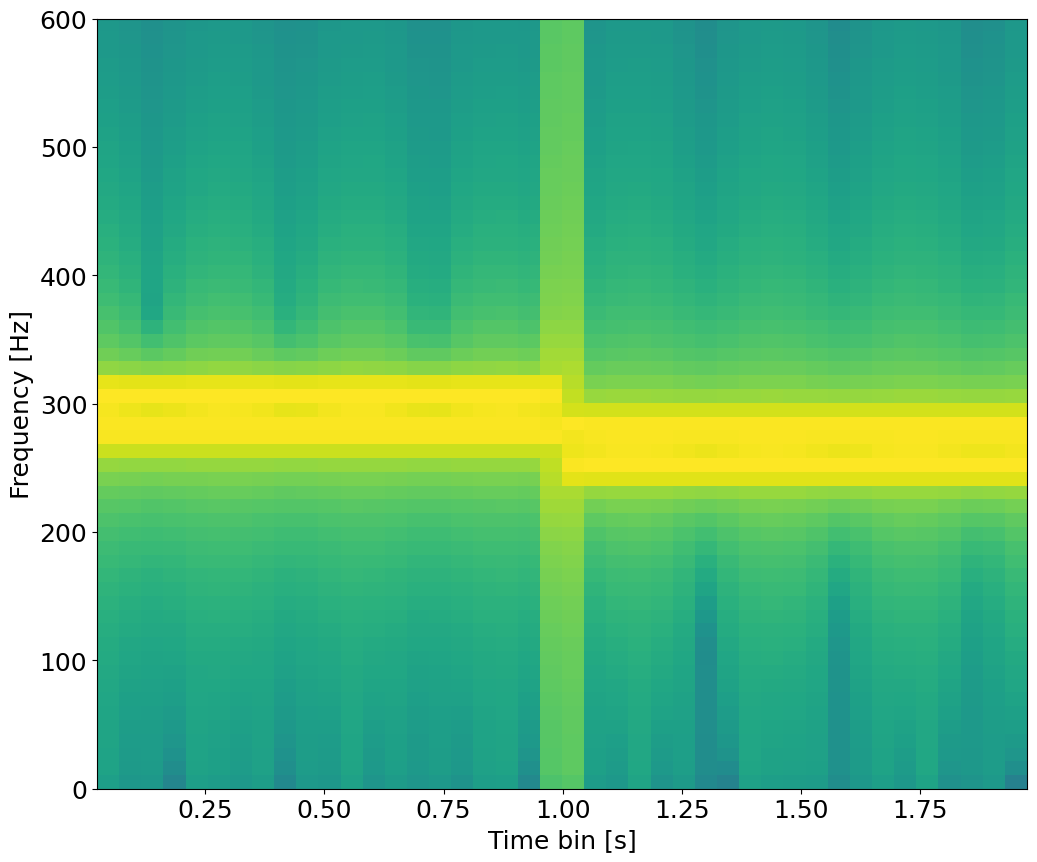

In [9]:
fig2 = plt.figure(figsize=(12, 10), facecolor='white')
plt.specgram(signals, NFFT=1024, Fs=11025, noverlap=512, cmap='viridis')
ax2 = plt.gca()
ax2.set_ylim([0, 600])
plt.xlabel('Time bin [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

# Harmonics

In [10]:
rate, song_array = wavfile.read('audios/sax_riff_mono.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'audios/sax_riff_mono.wav'

In [ ]:
def calc_specgram(song_array, NFFT, Fs, noverlap):
    spec, freqs, t = specgram(song_array, NFFT=NFFT, Fs=Fs, noverlap=noverlap)
    Z = 10.0 * np.log10(spec)
    Z = np.flipud(Z)
    extent = 0, len(t), freqs[0], freqs[-1]
    return Z, spec, freqs, t, extent

In [ ]:
def show_specgram(Z, cmap, extent):
    fig = plt.figure(figsize=(22, 10), facecolor='white')
    plt.imshow(Z, cmap=cmap, extent=extent)
    plt.title('Sax Riff Mono')
    plt.xlabel('Time bin')
    plt.ylabel('Frequency [Hz]')
    plt.axis('auto')
    ax = plt.gca()
    ax.set_xlim([0, extent[1]])
    plt.show()

In [ ]:
def cut_specgram(min_freq, max_freq, spec, freqs, t):
    spec_cut = spec[(freqs >= min_freq) & (freqs <= max_freq)]
    freqs_cut = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    Z_cut = 10.0 * np.log10(spec_cut)
    Z_cut = np.flipud(Z_cut)
    extent_cut = 0, len(t), freqs_cut[0], freqs_cut[-1]
    return Z_cut, spec_cut, freqs_cut, extent_cut

In [ ]:
Z, spec, freqs, t, extent = calc_specgram(song_array, 4096, rate, 2048)

In [ ]:
Z_cut, spec_cut, freqs_cut, extent_cut = cut_specgram(0, 4000, spec, freqs, t)

In [ ]:
display(Audio(data=song_array, rate=rate))

In [ ]:
extent_cut = extent = 0, len(t), freqs_cut[0], freqs_cut[-1]

In [ ]:
show_specgram(Z_cut, 'viridis', extent_cut)

## Song Fingerprinting

In [ ]:
rate1, song_array1 = wavfile.read('audios/youtube/Katy_Perry.wav')
rate2, song_array2 = wavfile.read('audios/youtube/Daft_Punk.wav')

In [ ]:
spec1, freqs1, t1 = specgram(song_array1, NFFT=4096, Fs=rate1, noverlap=2048)
spec2, freqs2, t2 = specgram(song_array2, NFFT=4096, Fs=rate2, noverlap=2048)

spec1[spec1 == 0] = 1e-6
spec2[spec2 == 0] = 1e-6

In [ ]:
fig1 = plt.figure(figsize=(26, 10), facecolor='white')
extent = 0, np.amax(t1), freqs1[0], freqs1[-1]
Z = 10.0 * np.log10(spec1)
Z = np.flipud(Z)
plt.imshow(Z, cmap='viridis', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Katy Perry song')
plt.axis('auto')
ax = plt.gca()
ax.set_xlim([0, extent[1]])
ax.set_ylim([freqs1[0], freqs1[-1]])
plt.show()

In [ ]:
def cut_specgram(min_freq, max_freq, spec, freqs):
    spec_cut = spec[(freqs >= min_freq) & (freqs <= max_freq)]
    freqs_cut = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    Z_cut = 10.0 * np.log10(spec_cut)
    Z_cut = np.flipud(Z_cut)
    return Z_cut, freqs_cut

In [ ]:
def show_peaks(Z, freqs, t, coord, title):
    fig = plt.figure(figsize=(26, 10), facecolor='white')
    plt.imshow(Z, cmap='viridis')
    plt.scatter(coord[:, 1], coord[:, 0])
    ax = plt.gca()
    plt.xlabel('Time bin')
    plt.ylabel('Frequency')
    plt.title(title, fontsize=18)
    plt.axis('auto')
    ax.set_xlim([0, len(t)])
    ax.set_ylim([len(freqs), 0])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()

In [ ]:
min_freq = 0
max_freq = 15000

Z1, freqs1 = cut_specgram(min_freq, max_freq, spec1, freqs1)
Z2, freqs2 = cut_specgram(min_freq, max_freq, spec2, freqs2)

In [ ]:
coordinates1 = peak_local_max(Z1, min_distance=20, threshold_abs=20)
coordinates2 = peak_local_max(Z2, min_distance=20, threshold_abs=20)

In [ ]:
show_peaks(Z1, freqs1, t1, coordinates1, 'Katy Perry song')

In [ ]:
show_peaks(Z2, freqs2, t2, coordinates2, 'Daft Punk song')